## Instructor Demo: Simulation of Stock Price Trajectory

This program executes a single simulation of stock price trajectory over the next `252` trading days (or year of trading) for `AAPL` stock, based on a normal probability distribution of historical average daily returns derived from the sample mean and standard deviation.

In [2]:
# Import libraries and dependencies
import os
import numpy as np
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = 'PKXH5GTGJSLBN4YCB590'
alpaca_secret_key = 'cvzssFtmO2l46EcPJqnR02XrthzuT0DP1GYmIiKU'

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [4]:
class Stock: 
    def __init__(self,ticker,start_dt,end_dt, timeframe = "1D", initial_investment=10000):
        
        self.ticker=ticker
        self.start_dt =start_dt
        self.end_dt = end_dt
        self.timeframe = timeframe
        self.initial_investment=initial_investment
        self.ticker_data = self.get_ticker_data()
        self.MC_AAPL = self.get_MC()
        self.plot_simulation()
        self.simulated_returns =self.get_simulated_returns()
        self.simulated_profit = self.get_simulated_profit()
        self.mc_summary = self.get_forecast()
    
    
    def get_ticker_data(self):
         
        ticker_data = api.get_barset(
        self.ticker,
        self.timeframe,
        start=self.start_dt,
        end=self.end_dt,
        limit=1000,
        ).df
        
        self.available_dates = [x.strftime('%Y-%m-%d') for x in ticker_data.index]
        
        self.first_min_date =[x for x in self.available_dates if x>=self.start_dt][0]
        self.first_max_date =[x for x in self.available_dates if x<=self.end_dt][-1]
        
        ticker_data = ticker_data.loc[self.first_min_date: self.first_max_date]
        return ticker_data
    
        # Set number of simulations
        
    def get_MC(self, num_sims=500): 
        return MCSimulation(
            portfolio_data = self.ticker_data,
            num_simulation = num_sims,
            num_trading_days = 252
        )
        
    def plot_simulation(self):     

        # Configure a Monte Carlo simulation to forecast one year daily returns

        line_plot = self.MC_AAPL.plot_simulation()
        
        return line_plot
    
    def get_simulated_returns(self): 
        # Compute summary statistics from the simulated daily returns
        simulated_returns_data = {
            "mean": list(self.MC_AAPL.simulated_return.mean(axis=1)),
            "median": list(self.MC_AAPL.simulated_return.median(axis=1)),
            "min": list(self.MC_AAPL.simulated_return.min(axis=1)),
            "max": list(self.MC_AAPL.simulated_return.max(axis=1))
        }

        # Create a DataFrame with the summary statistics
        df_simulated_returns = pd.DataFrame(simulated_returns_data)

        # Display sample data
        return df_simulated_returns
    
    
    def get_simulated_profit(self): 
        # Set initial investment
#         initial_investment = 10000

        # Multiply an initial investment by the daily returns of simulative stock prices to return the progression of daily returns in terms of money
        cumulative_pnl = self.initial_investment * self.simulated_returns

        return cumulative_pnl

    def plot_simulated_returns(self): 
        self.simulated_returns.plot(title="Simulated Daily Returns Behavior of AAPL Stock Over the Next Year")
    
            
    def get_forecast(self): 
        tbl = self.MC_AAPL.summarize_cumulative_return()


        # Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in AAPL stocks
        self.ci_lower = round(tbl[8]*10000,2)
        self.ci_upper = round(tbl[9]*10000,2)

        # Print results
        print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
              f" over the next year will end within in the range of"
              f" ${self.ci_lower} and ${self.ci_upper}.")

                # Fetch summary statistics from the Monte Carlo simulation results
        mc_summary = self.MC_AAPL.summarize_cumulative_return()

        # Print summary statistics
        
        return mc_summary 
    
    

### Get 5 Years Worth of Data via API Call and Read in as DataFrame 

/Users/armandoordorica/Documents/Stocks_Alpaca/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


There is a 95% chance that an initial investment of $10,000 in the portfolio over the next year will end within in the range of $15182.78 and $32831.75.


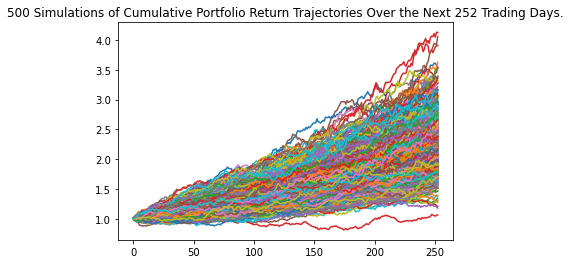

In [5]:
apple = Stock('AAPL', '2021-10-01', '2021-12-05')


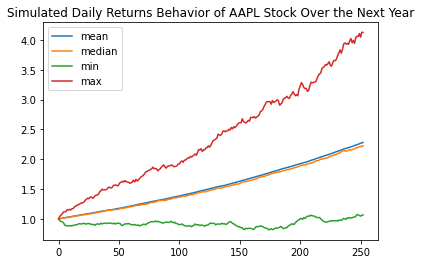

In [6]:
apple.plot_simulated_returns()

In [7]:
apple.simulated_returns

mean    median       min       max
0    1.000000  1.000000  1.000000  1.000000
1    1.003492  1.003504  0.968042  1.043818
2    1.007087  1.008048  0.956035  1.061945
3    1.010740  1.010565  0.949370  1.082108
4    1.013477  1.013566  0.936039  1.114660
..        ...       ...       ...       ...
248  2.251943  2.202756  1.064186  4.055277
249  2.257194  2.208115  1.056549  4.105833
250  2.263675  2.216034  1.044619  4.046077
251  2.272279  2.209396  1.059700  4.128428
252  2.280179  2.225211  1.064954  4.125125

[253 rows x 4 columns]

In [8]:
apple.get_forecast()

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next year will end within in the range of $15182.78 and $32831.75.


count           500.000000
mean              2.280179
std               0.473281
min               1.064954
25%               1.956341
50%               2.225211
75%               2.600874
max               4.125125
95% CI Lower      1.518278
95% CI Upper      3.283175
Name: 252, dtype: float64

### Run the Monte Carlo Simulation